### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape data to 2D (flatten images)
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
from sklearn.ensemble import RandomForestClassifier

# Train a baseline model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
accuracy = model.score(X_test, y_test)
print(f"Baseline Model Accuracy: {accuracy:.4f}")

Baseline Model Accuracy: 0.8764


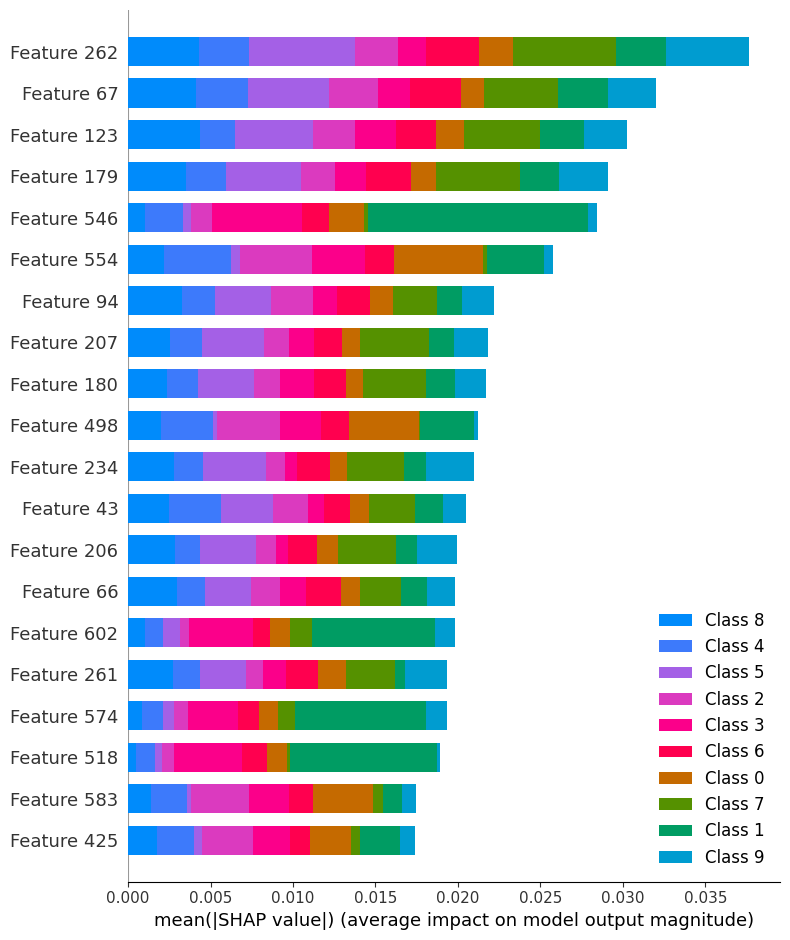

In [7]:
import shap

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[:100])  # Use a subset for faster computation

# Visualize feature importance
shap.summary_plot(shap_values, X_test[:100], plot_type="bar")

In [8]:
# Example: Select top features based on SHAP results
top_features = [262, 67, 123, 179, 546, 554, 94, 207, 180, 498, 234, 43, 206, 66, 602, 261, 574, 518, 583, 425]

# Filter dataset to keep only top features
X_train_top = X_train[:, top_features]
X_test_top = X_test[:, top_features]

In [9]:
from scipy.ndimage import sobel

# Reshape data back to images (28x28)
X_train_images = X_train.reshape(-1, 28, 28)
X_test_images = X_test.reshape(-1, 28, 28)

# Apply Sobel filter for edge detection
X_train_edges = np.array([sobel(img) for img in X_train_images])
X_test_edges = np.array([sobel(img) for img in X_test_images])

# Flatten the edge-detected images
X_train_edges = X_train_edges.reshape(-1, 28 * 28)
X_test_edges = X_test_edges.reshape(-1, 28 * 28)

# Combine original features with edge features
X_train_combined = np.hstack([X_train_top, X_train_edges[:, top_features]])
X_test_combined = np.hstack([X_test_top, X_test_edges[:, top_features]])

In [10]:
# Retrain the model with refined features
model_refined = RandomForestClassifier(random_state=42)
model_refined.fit(X_train_combined, y_train)

# Evaluate the refined model
accuracy_refined = model_refined.score(X_test_combined, y_test)
print(f"Refined Model Accuracy: {accuracy_refined:.4f}")

Refined Model Accuracy: 0.8119


Module 3

In [30]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
import numpy as np

# Initialize H2O
h2o.init()

# Convert to H2O frames
train = h2o.H2OFrame(np.hstack([X_train, y_train.reshape(-1, 1)]))
test = h2o.H2OFrame(np.hstack([X_test, y_test.reshape(-1, 1)]))

# Set column names
feature_names = [f"f{i}" for i in range(X_train.shape[1])]
column_names = feature_names + ["label"]
train.columns = column_names
test.columns = column_names

# Convert the target column to a factor (for classification)
train["label"] = train["label"].asfactor()
test["label"] = test["label"].asfactor()

# Define features and target
x = feature_names
y = "label"

# Run H2O AutoML
aml = H2OAutoML(max_models=10, seed=42, max_runtime_secs=300)  # Adjust runtime as needed
aml.train(x=x, y=y, training_frame=train)

# Get the leaderboard
leaderboard = aml.leaderboard

# Print the leaderboard
print("Leaderboard:")
print(leaderboard)

# Get the best model
best_model = aml.leader

# Evaluate the best model on the test set
performance = best_model.model_performance(test)

# Get the confusion matrix as a Pandas DataFrame
confusion_matrix = performance.confusion_matrix().as_data_frame()
print("Confusion Matrix (Raw):")
print(confusion_matrix)

# Extract only the numeric part of the confusion matrix (ignore the last row and last column)
numeric_matrix = confusion_matrix.iloc[:-1, :-1].astype(float)

# Print the cleaned numeric matrix
print("Cleaned Numeric Matrix:")
print(numeric_matrix)

# Calculate accuracy
correct_predictions = np.trace(numeric_matrix)  # Sum of diagonal elements
total_predictions = numeric_matrix.values.sum()
accuracy = correct_predictions / total_predictions

print(f"Best Model Test Accuracy: {accuracy}")

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,27 mins 55 secs
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 20 days
H2O_cluster_name:,H2O_from_python_datascience_mm3iyl
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.468 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Leaderboard:
model_id                              mean_per_class_error    logloss      rmse      mse
XGBoost_1_AutoML_3_20250322_130826                0.119857   0.351096  0.330107  0.10897
[1 row x 5 columns]

Confusion Matrix (Raw):
         0      1       2       3       4      5      6       7       8  \
0    843.0    0.0    19.0    36.0     5.0    1.0   83.0     0.0    13.0   
1      2.0  961.0     2.0    24.0     3.0    0.0    6.0     0.0     2.0   
2     18.0    0.0   810.0    11.0    94.0    0.0   63.0     0.0     4.0   
3     28.0    5.0     9.0   890.0    24.0    0.0   42.0     0.0     2.0   
4      1.0    0.0   114.0    34.0   783.0    0.0   65.0     0.0     3.0   
5      1.0    0.0     1.0    

In [33]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    }
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-03-22 13:42:06,289] A new study created in memory with name: no-name-6bde0f02-dae0-45ae-9754-c0f9292b8ce9
[I 2025-03-22 13:43:10,018] Trial 0 finished with value: 0.8732 and parameters: {'n_estimators': 76, 'max_depth': 21, 'min_samples_split': 8}. Best is trial 0 with value: 0.8732.
[I 2025-03-22 13:45:04,655] Trial 1 finished with value: 0.8745 and parameters: {'n_estimators': 136, 'max_depth': 24, 'min_samples_split': 3}. Best is trial 1 with value: 0.8745.
[I 2025-03-22 13:47:00,437] Trial 2 finished with value: 0.8638 and parameters: {'n_estimators': 191, 'max_depth': 13, 'min_samples_split': 10}. Best is trial 1 with value: 0.8745.
[I 2025-03-22 13:48:31,724] Trial 3 finished with value: 0.8765 and parameters: {'n_estimators': 105, 'max_depth': 39, 'min_samples_split': 5}. Best is trial 3 with value: 0.8765.
[I 2025-03-22 13:50:08,277] Trial 4 finished with value: 0.8755 and parameters: {'n_estimators': 114, 'max_depth': 24, 'min_samples_split': 5}. Best is trial 3 with v

Best Hyperparameters: {'n_estimators': 105, 'max_depth': 39, 'min_samples_split': 5}
